In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset Path
train_dir = '/content/drive/MyDrive/bisindo_dataset_split/train'
val_dir = '/content/drive/MyDrive/bisindo_dataset_split/val'
test_dir = '/content/drive/MyDrive/bisindo_dataset_split/test'

In [ ]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

# data_augmentation = tf.keras.Sequential([
#     # tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomZoom(0.2),
#     tf.keras.layers.RandomContrast(0.3),
#     tf.keras.layers.RandomTranslation(0.15, 0.15),
#     tf.keras.layers.GaussianNoise(0.1),
# ], name="data_augmentation")

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names before prefetching
class_names = train_ds.class_names

# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 3126 files belonging to 26 classes.
Found 670 files belonging to 26 classes.
Found 670 files belonging to 26 classes.


In [ ]:
# Build the model with data augmentation inside
base_model = tf.keras.applications.VGG19(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

# Model definition
model = tf.keras.Sequential([
    # data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
EPOCHS = 20  # You can adjust this

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1312s 13s/step - accuracy: 0.1655 - loss: 3.6108 - val_accuracy: 0.1463 - val_loss: 3.4570
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 59s 285ms/step - accuracy: 0.4788 - loss: 2.2150 - val_accuracy: 0.2493 - val_loss: 3.0850
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.5705 - loss: 1.8352 - val_accuracy: 0.3806 - val_loss: 2.6422
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.6525 - loss: 1.5620 - val_accuracy: 0.4970 - val_loss: 2.2603
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.6908 - loss: 1.4033 - val_accuracy: 0.4791 - val_loss: 2.0795
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - accuracy: 0.7321 - loss: 1.2607 - val_accuracy: 0.4552 - val_loss: 2.2470
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.7414 - loss: 1.2131 - val_accuracy: 0.5179 - val_loss: 2.1596
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - accuracy: 0.7673 - loss: 1.1090 - val_accu

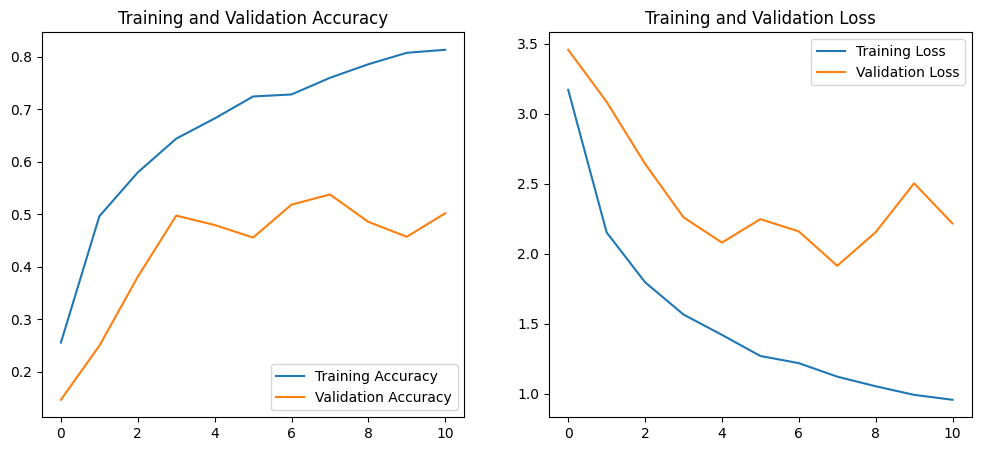

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
Classification Report:

              precision    recall  f1-score   support

           A       0.70      0.79      0.75        24
           B       0.83      0.38      0.53     

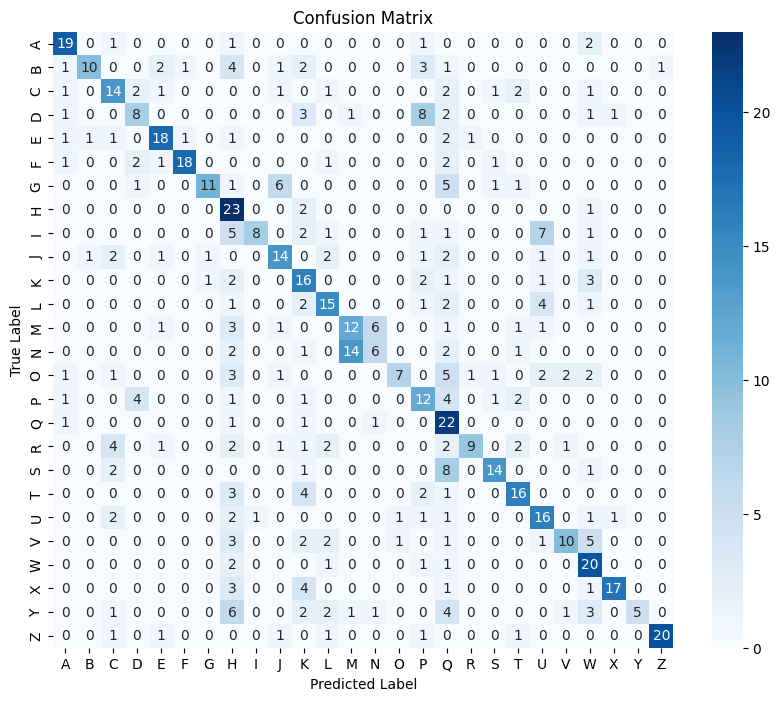

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# --- Add this code to the end of your MobileNetV2 and VGG19 notebooks ---
import time
import numpy as np

# Reload the test dataset without shuffling to get a consistent sample
test_ds_inf = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Take a few batches to average over (e.g., 5 batches * 32 images/batch = 160 images)
inference_samples = test_ds_inf.take(5)
total_time = 0
num_images = 0

print("Calculating inference time...")
for images, labels in inference_samples:
    start_time = time.time()
    _ = model.predict(images, verbose=0)
    end_time = time.time()

    total_time += (end_time - start_time)
    num_images += len(images)

avg_inference_time_ms = (total_time / num_images) * 1000
print(f"Total images tested: {num_images}")
print(f"Average inference time: {avg_inference_time_ms:.4f} ms per image")

Found 670 files belonging to 26 classes.
Calculating inference time...
Total images tested: 160
Average inference time: 11.1163 ms per image
